Prediction of the target variable using word2vec.
5 different embedding sizes are checked: 10, 20, 30, 40, 50.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

2024-02-07 10:10:52.861299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 10:10:53.914531: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Import the graph

In [2]:
# List of edges

# edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные
edges = pd.read_csv("../dat/edges.csv", sep=",")
print((edges.shape))  # (594174, 2)
edges.head()

(594174, 3)


,Unnamed: 0,node_1,node_2
0,0,344,50
1,1,344,153
2,2,344,532
3,3,344,679
4,4,344,986


In [3]:
# Convert into a graph
G = nx.from_pandas_edgelist(edges, "node_1", "node_2")
print(type(G))
print("The graph contains", G.number_of_nodes(), "nodes (proteins).")  # 10000
print("and", G.number_of_edges(), "edges.")  # 594174, OK
print("It has", nx.number_connected_components(G) , "connected component(s).")  # 1

<class 'networkx.classes.graph.Graph'>
The graph contains 10000 nodes (proteins).
and 594174 edges.
It has 1 connected component(s).


Load train, test sets.

In [4]:
# load train, test
train = pd.read_csv("../dat/train.csv", sep=",")
test = pd.read_csv("../dat/test.csv", sep=",")

print(train.shape)  # (8000, 2)
train.head()

(8000, 3)


,Unnamed: 0,target,node
0,0,0.251968,11142
1,1,0.689541,2243
2,2,0.678245,15514
3,3,0.272500,20944
4,4,0.248888,8721


# Generate features.
This solution runs 4 slightly different models. Each one used the random walks, then word2vec for generating features. 

The models differ in the dimension of the embedding space.
This allows producing common random walks to all 4 models, which makes economy of computation time.

Common hyperparameters for all models.

In [5]:
len_walk = 20
num_runs = 5
p_ret = 0.4

num_workers = 4

In [6]:
%%time
# Random walks 

g_st = StellarGraph.from_networkx(G)
rw = BiasedRandomWalk(g_st, seed=42)

nodes = g_st.nodes()  # the list of nodes is also used in the main loop below
walks = rw.run(nodes=list(nodes), length=len_walk, n=num_runs, p=p_ret, seed=42)
str_walks = [list(map(str, w)) for w in walks]

print(type(nodes))

<class 'pandas.core.indexes.base.Index'>
CPU times: user 1min 8s, sys: 130 ms, total: 1min 8s
Wall time: 1min 8s


In [7]:
# The regression model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=1, n_jobs=num_workers)

Loop of training the regressor with different embedding sizes in a loop over different embedding sizes.

In [8]:
# Different embedding sizes.
emb_sizes = list(range(10,60,10))

errors_train = []
errors_test = []  # lists for keeping the final results

In [9]:
%%time

# Main loop, which computes features using word2vec, gathers the features into DataFrames, fits the regression model.
for emb_size in emb_sizes:
    model = Word2Vec(str_walks, vector_size=emb_size, workers=num_workers)
    fts = np.array([model.wv[str(node)] for node in nodes])
    df_fts = pd.DataFrame(np.column_stack([nodes, fts]))
    
    # rename the columns of features
    ft_col_names =  ['X_{}'.format(i) for i in range(fts.shape[1])]
    columns = ['node'] + ft_col_names
    df_fts.columns = columns
    
    # convert the node indices to integer type for compatibility with train, test sets.
    df_fts['node'] =  df_fts['node'].astype(int)
    
    # subdivide the DF of features, in accordance with the node numbers of loaded train , test.
    df_train_all_cols = df_fts.merge(train[['target', 'node']], on='node')
    df_test_all_cols = df_fts.merge(test[['target', 'node']], on='node')
    
    # Train the regression model.
    rf_model.fit(df_train_all_cols[ft_col_names], df_train_all_cols['target'])
    
    # Check its performance on training, test set.
    preds_train = rf_model.predict(df_train_all_cols[ft_col_names])
    preds_test= rf_model.predict(df_test_all_cols[ft_col_names])
    MSE_train = mean_squared_error(df_train_all_cols['target'], preds_train)
    MSE_test = mean_squared_error(df_test_all_cols['target'], preds_test)
    
    # Save the results
    errors_train.append(MSE_train)
    errors_test.append(MSE_test)

CPU times: user 1min 17s, sys: 199 ms, total: 1min 17s
Wall time: 21 s


In [10]:
print(errors_train)  # [0.04463495428256618, 0.04208853935252243, 0.033677512846114865, 0.03117192273816171]
print('--------')
print(errors_test)  # [0.2472448349163108, 0.2306186502724652, 0.19742922646423966, 0.18955174245420087]

[0.04331762567987676, 0.03904543658561399, 0.03294009725827652, 0.03216821355056928, 0.033491144032919584]
--------
[0.22973125183038687, 0.22972525064759045, 0.16818560844737782, 0.1974363373507506, 0.20082750680227968]


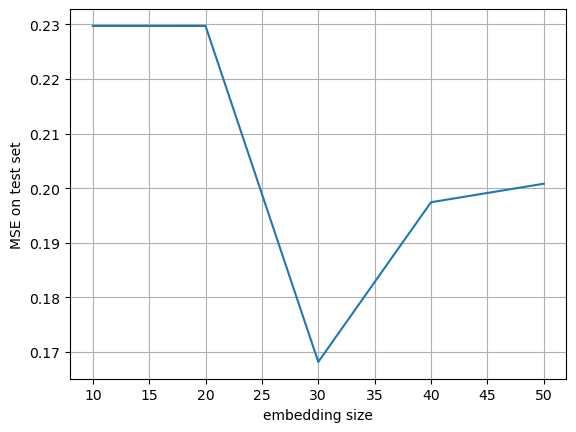

In [11]:
# Plot the error on test set as a function of embedding size
plt.plot(emb_sizes, errors_test)
plt.grid(True)
plt.xlabel('embedding size')
plt.ylabel('MSE on test set')
plt.show()

The best error on test set is of order of 0.2. This clearly beats the dummy prediction.

The results show some random behavior due to the embedding 'word2vec', see:

https://github.com/piskvorky/gensim/wiki/Recipes-&-FAQ#q11-ive-trained-my-word2vecdoc2vecetc-model-repeatedly-using-the-exact-same-text-corpus-but-the-vectors-are-different-each-time-is-there-a-bug-or-have-i-made-a-mistake-2vec-training-non-determinism
" So, it is to be expected that models vary from run to run, even trained on the same data."


The optimal embedding size seems to be 30. Indeed, the error on test set remains stable or increases afterwards.
The error on test set is at least 4 times the error on training set. This property of the model seems inherent and independent of the the embedding size. 